<a href="https://colab.research.google.com/github/HuynhVietDung/rfm-and-masket-basket-analyst/blob/main/RFM_Analyst_%26_Market_Basket_Analyst.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Association Rule & RFM Analyst

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## Load Data

In [3]:
df = pd.read_excel('./OnlineRetail.xlsx')

In [4]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


## Clean Data

In [6]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [7]:
# Data cleaning
df['Description'] = df['Description'].str.strip() # remove spaces
df.dropna(axis = 0, subset = ['InvoiceNo'], inplace = True) # remove duplicate invoice
df['InvoiceNo'] = df['InvoiceNo'].astype('str') # converting invoice number to string
df = df[~df['InvoiceNo'].str.contains('C')] #remove credit transactions
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## RFM Analyst & Clustering Customers

RFM Analyst (Recency, Frequency, Monetary Analyst) is an individual or a role in the field of marketing and data analysis. RFM stands for three key factors that an RFM Analyst uses to analyze customer data and identify potential or high-value customer segments. The RFM factors are: Recency (R), Frequency (F) and Monetary (M).

RFM Analysts use these three factors to rank and categorize customers into different groups, helping businesses focus on those customers with the highest potential to optimize marketing strategies and interactions. RFM analysis provides an overview of various critical customer behavior insights, aiding businesses in making decisions on how to approach and serve customers more effectively.

### Recency
Represents how recently a customer has made a purchase or interacted with a business. It is often measured in terms of the number of days or months since the customer's last transaction or interaction.

In [8]:
# The lastest day in InvoiceDate is 9/12/2011. We will set today is 31/12/2011
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

In [9]:
today = "2011-12-31"
today = pd.to_datetime(today)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [10]:
df['InvoiceDate']

0        2010-12-01 08:26:00
1        2010-12-01 08:26:00
2        2010-12-01 08:26:00
3        2010-12-01 08:26:00
4        2010-12-01 08:26:00
                 ...        
541904   2011-12-09 12:50:00
541905   2011-12-09 12:50:00
541906   2011-12-09 12:50:00
541907   2011-12-09 12:50:00
541908   2011-12-09 12:50:00
Name: InvoiceDate, Length: 532621, dtype: datetime64[ns]

In [11]:
recency_table = df.groupby(['CustomerID']).agg({'InvoiceDate': lambda x: ((today - x.max()).days)})

recency_table.columns = ['Recency']
recency_table.head()

,Recency
CustomerID,
12346.0,346
12347.0,23
12348.0,96
12349.0,39
12350.0,331


### Frequency
Denotes how often a customer has made purchases or interacted within a specific time frame. Frequency indicates the rate at which a customer buys or interacts.

In [12]:
frequency_table = df.drop_duplicates(subset = 'InvoiceNo').groupby(['CustomerID'])[['InvoiceNo']].count()
frequency_table.columns = ['Frequency']
frequency_table.head()

,Frequency
CustomerID,
12346.0,1
12347.0,7
12348.0,4
12349.0,1
12350.0,1


### Monetary
Refers to the total value of all the transactions a customer has made. Monetary measures the overall value that a customer brings to the business.

In [13]:
df['Total_Price'] = df['Quantity']*df['UnitPrice']

monetary_table = df.groupby(['CustomerID'])[['Total_Price']].sum()
monetary_table.columns = ['Monetary']
monetary_table.head()

,Monetary
CustomerID,
12346.0,77183.60
12347.0,4310.00
12348.0,1797.24
12349.0,1757.55
12350.0,334.40


In [14]:
rfm_data = pd.concat([recency_table, frequency_table, monetary_table], axis = 1)
rfm_data.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,346,1,77183.60
12347.0,23,7,4310.00
12348.0,96,4,1797.24
12349.0,39,1,1757.55
12350.0,331,1,334.40


In [15]:
rfm_data.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 4339 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    4339 non-null   int64  
 1   Frequency  4339 non-null   int64  
 2   Monetary   4339 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 135.6 KB


### Clustering Customers

In [16]:
# Scale rfm_data
scaler = StandardScaler()
rfm_scaled_data = scaler.fit_transform(rfm_data)
rfm_scaled_data

array([[ 2.32967293e+00, -4.24674873e-01,  8.35963391e+00],
       [-9.00448767e-01,  3.54080191e-01,  2.51046358e-01],
       [-1.70421263e-01, -3.52973410e-02, -2.85464504e-02],
       ...,
       [-8.50446884e-01, -2.94882363e-01, -2.08712435e-01],
       [-8.90448391e-01,  1.52221279e+00,  4.57171586e-03],
       [-5.00433697e-01, -1.65089852e-01, -2.40912314e-02]])

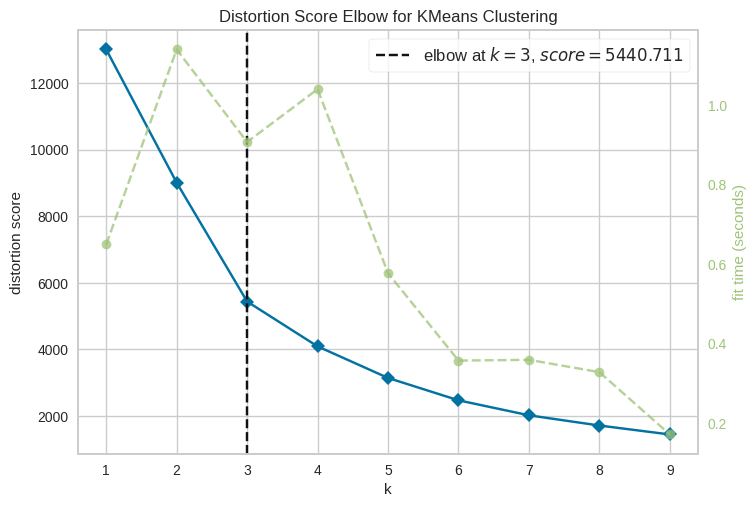

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
# Find optimal number of groups using Elbow
elbow_method = KElbowVisualizer(KMeans(random_state = 42), k=(1,10))
elbow_method.fit(rfm_scaled_data)
elbow_method.show()

In [18]:
## The optimal k = 3. Let's cluster custumers into 3 clusters

kmeans = KMeans(n_clusters = elbow_method.elbow_value_)
kmeans.fit(rfm_scaled_data)
rfm_data["Cluster"] = (kmeans.labels_)
rfm_data

,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,346,1,77183.60,1
12347.0,23,7,4310.00,0
12348.0,96,4,1797.24,0
12349.0,39,1,1757.55,0
12350.0,331,1,334.40,1
...,...,...,...,...
18280.0,298,1,180.60,1
18281.0,201,1,80.82,1
18282.0,28,2,178.05,0


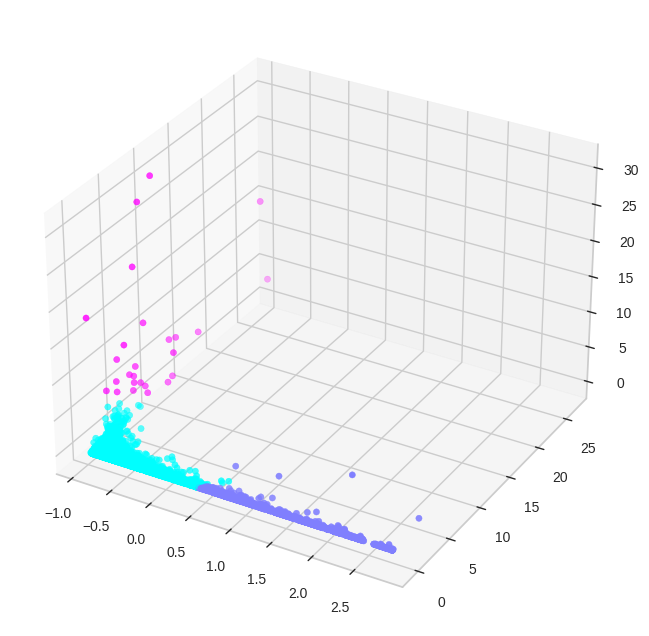

In [34]:
# visualize customers clusters
labels = rfm_data["Cluster"]
plt.figure(figsize=(12, 8))
ax = plt.subplot(projection="3d")
ax.scatter(rfm_scaled_data[:, 0] , rfm_scaled_data[:, 1], rfm_scaled_data[:, 2], c = labels, cmap="cool")
plt.show()

In [19]:
rfm_data.groupby(["Cluster"])[["Recency", "Frequency", "Monetary"]].mean()

,Recency,Frequency,Monetary
Cluster,,,
0,61.821761,4.676999,1857.169902
1,267.122355,1.581417,631.706220
2,26.461538,66.500000,85904.351538


## Association Rule with Apriori

Association rules are a type of data mining technique used in data analysis and knowledge discovery. They are primarily used to discover interesting relationships or patterns within large datasets

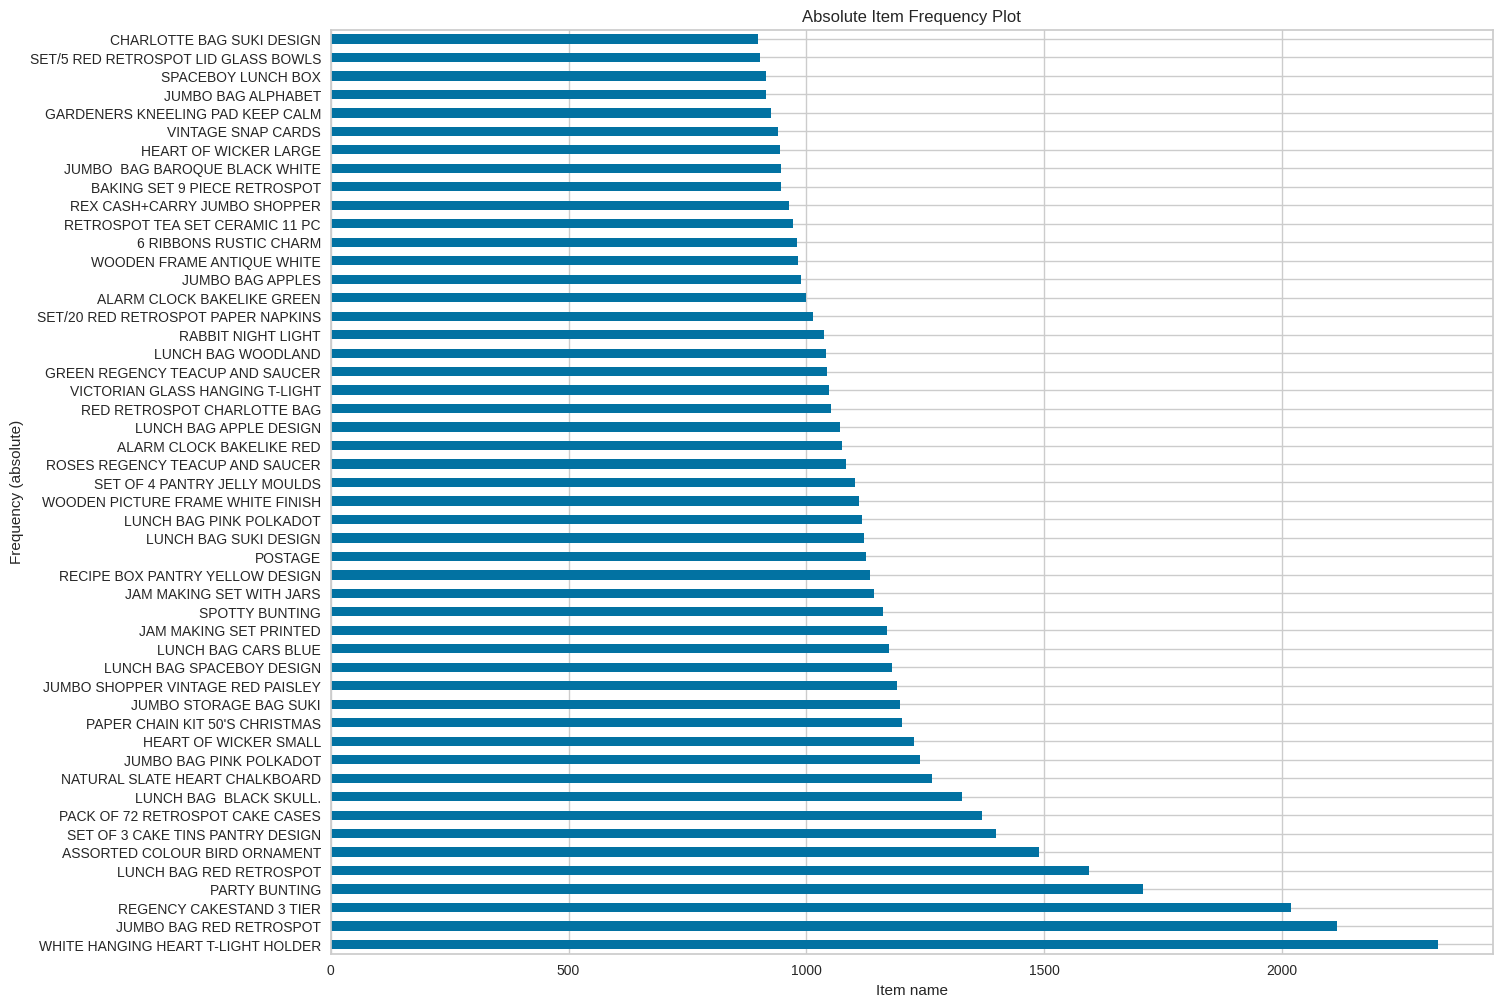

In [20]:
## Top 50 Frequency Item
top_50_item = df['Description'].value_counts().head(50).sort_values(ascending=False)

plt.figure(figsize = (15, 12))
top_50_item.plot(kind='barh')
plt.title('Absolute Item Frequency Plot')
plt.xlabel('Item name')
plt.ylabel('Frequency (absolute)')
plt.show()

In [21]:
df['Country'].value_counts()

United Kingdom          487622
Germany                   9042
France                    8408
EIRE                      7894
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1967
Portugal                  1501
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Unspecified                446
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     295
Hong Kong                  284
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon 

In [22]:
# converting all positive values to 1 and everything else to 0
def my_encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

# generate basket dataframe by country
def generate_basket_set(df, country):
  # Separating transactions for 'country'
  my_basket = (df[df['Country'] == country]
            .groupby(['InvoiceNo', 'Description'])['Quantity']
            .sum().unstack().reset_index().fillna(0)
            .set_index('InvoiceNo'))

  my_basket_sets = my_basket.applymap(my_encode_units)
  my_basket_sets.drop('POSTAGE', inplace = True, axis = 1) # Remove "postage" as an item
  return my_basket_sets

# generate basket dataframe for Germany
my_basket_sets = generate_basket_set(df, 'Germany')

### Generate Frequent Itemset & Association Rules

Association rules consist of two main components:

* Antecedent (left-hand side): This represents a set of items or conditions that are observed or found to be present in the dataset.

* Consequent (right-hand side): This represents the item or condition that is likely to co-occur with the antecedent.

These rules are often expressed in the form of "IF [Antecedent] THEN [Consequent]." For example, in a retail context, an association rule might indicate that "IF a customer purchases bread and milk (Antecedent), THEN the customer is likely to buy eggs (Consequent)."

The key metrics used in association rule mining are support, confidence, and lift:

* Support: This measures the frequency or occurrence of a specific itemset (combination of items) in the dataset. It indicates how often a particular rule is applicable. High support implies that the rule is relevant to a significant portion of the dataset.

* Confidence: This measures the reliability or strength of the association rule. It quantifies the likelihood that the Consequent will occur when the Antecedent is present. Higher confidence values indicate a stronger association.

* Lift: Lift is used to measure the strength of association between the Antecedent and the Consequent while taking into account how often the Consequent occurs independently of the Antecedent. A lift value greater than 1 suggests a positive association, indicating that the presence of the Antecedent increases the likelihood of the Consequent.






In [23]:
# Generating frequent itemsets
my_frequent_itemsets = apriori(my_basket_sets, min_support = 0.02, use_colnames = True)

In [24]:
my_rules = association_rules(my_frequent_itemsets, metric = 'lift', min_threshold = 1)

In [25]:
my_rules.head(100)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ROUND SNACK BOXES SET OF4 WOODLAND),(3 PIECE SPACEBOY COOKIE CUTTER SET),0.245077,0.041575,0.021882,0.089286,2.147556,0.011693,1.052388,0.707826
1,(3 PIECE SPACEBOY COOKIE CUTTER SET),(ROUND SNACK BOXES SET OF4 WOODLAND),0.041575,0.245077,0.021882,0.526316,2.147556,0.011693,1.593727,0.557534
2,(CHOCOLATE BOX RIBBONS),(6 RIBBONS RUSTIC CHARM),0.037199,0.102845,0.021882,0.588235,5.719650,0.018056,2.178806,0.857045
3,(6 RIBBONS RUSTIC CHARM),(CHOCOLATE BOX RIBBONS),0.102845,0.037199,0.021882,0.212766,5.719650,0.018056,1.223017,0.919756
4,(PLASTERS IN TIN CIRCUS PARADE),(6 RIBBONS RUSTIC CHARM),0.115974,0.102845,0.024070,0.207547,2.018065,0.012143,1.132125,0.570657
...,...,...,...,...,...,...,...,...,...,...
95,(CHILDRENS APRON APPLES DESIGN),(ROUND SNACK BOXES SET OF4 WOODLAND),0.041575,0.245077,0.021882,0.526316,2.147556,0.011693,1.593727,0.557534
96,(CHILDRENS CUTLERY CIRCUS PARADE),(CHILDRENS CUTLERY DOLLY GIRL),0.037199,0.050328,0.021882,0.588235,11.687980,0.020010,2.306346,0.949773
97,(CHILDRENS CUTLERY DOLLY GIRL),(CHILDRENS CUTLERY CIRCUS PARADE),0.050328,0.037199,0.021882,0.434783,11.687980,0.020010,1.703417,0.962903
98,(CHILDRENS CUTLERY CIRCUS PARADE),(CHILDRENS CUTLERY SPACEBOY),0.037199,0.048140,0.021882,0.588235,12.219251,0.020091,2.311660,0.953636


### Some Rules

In [28]:
#Filtering rules base on condition
my_rules[(my_rules['lift'] >= 3) &
         (my_rules['confidence'] >= 0.3)].sort_values(by = "confidence", ascending = False)[:10]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
510,"(JUMBO BAG PINK POLKADOT, JUMBO BAG WOODLAND A...",(JUMBO BAG RED RETROSPOT),0.026258,0.078775,0.026258,1.000000,12.694444,0.024190,inf,0.946067
468,"(ROUND SNACK BOXES SET OF 4 FRUITS, BLUE HARMO...",(ROUND SNACK BOXES SET OF4 WOODLAND),0.021882,0.245077,0.021882,1.000000,4.080357,0.016519,inf,0.771812
666,"(SPACEBOY LUNCH BOX, RED RETROSPOT CHARLOTTE BAG)",(WOODLAND CHARLOTTE BAG),0.021882,0.126915,0.021882,1.000000,7.879310,0.019105,inf,0.892617
660,"(ROUND SNACK BOXES SET OF4 WOODLAND, RED RETRO...",(WOODLAND CHARLOTTE BAG),0.030635,0.126915,0.030635,1.000000,7.879310,0.026747,inf,0.900677
654,"(RED RETROSPOT CHARLOTTE BAG, RED TOADSTOOL LE...",(WOODLAND CHARLOTTE BAG),0.024070,0.126915,0.024070,1.000000,7.879310,0.021015,inf,0.894619
514,"(WOODLAND CHARLOTTE BAG, JUMBO BAG RED RETROSPOT)",(JUMBO BAG WOODLAND ANIMALS),0.024070,0.100656,0.024070,1.000000,9.934783,0.021647,inf,0.921525
68,(PINK VINTAGE SPOT BEAKER),(BLUE VINTAGE SPOT BEAKER),0.024070,0.030635,0.024070,1.000000,32.642857,0.023333,inf,0.993274
126,(DOLLY GIRL CHILDRENS CUP),(DOLLY GIRL CHILDRENS BOWL),0.024070,0.026258,0.024070,1.000000,38.083333,0.023438,inf,0.997758
125,(DINOSAUR PARTY BAG + STICKER SET),(WOODLAND PARTY BAG + STICKER SET),0.021882,0.067834,0.021882,1.000000,14.741935,0.020398,inf,0.953020
689,"(SPACEBOY LUNCH BOX, ROUND SNACK BOXES SET OF ...",(ROUND SNACK BOXES SET OF4 WOODLAND),0.039387,0.245077,0.037199,0.944444,3.853671,0.027546,13.588621,0.770870
